In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import math
import statsmodels.api as sm
plt.rcParams['savefig.dpi'] = 600
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec

## Importing the data

In [3]:
# SortSeq scores for all mutants
sort_all_scores = pd.read_csv("Supp_data/Sort_scores_all.csv")

# Data for the calibration curve (validation fluorescence and boostrapped lowess)
curve_eval_df = pd.read_csv('Supp_data/Calib_lowess_bootstrap.csv')
sort_comp = pd.read_csv('Supp_data/Sort_valid_comp.csv')

# Inferred distribution of mutational effects
exp_predict_df = pd.read_csv('Supp_data/Rel_exp_fcy1_bootstrap.csv')

In [4]:
# TFBS hits from YetFasco
TFBS_hits = pd.read_csv("Supp_data/YetFasco_FCY1prom_pe300_output_25-07-10_SA.csv")

## Preparing the data

### Distribution of all Sort-seq scores (for panel B)

In [7]:
# Adding a clearer identification for F3-F4 mutants and secondary mutations
sort_all_scores['Genotype_category'] = np.where(sort_all_scores['In_F3F4'], 'F3-F4', 'Other')

# Selecting the validation mutants (only those that were successfully reconstructed)
sort_scores_valid = pd.merge(sort_all_scores[['Genotype', 'Position', 'Mutation type', 'FCY1_position', 'Genotype_category',
                                             'Median_delta_WT', 'Min_delta_WT', 'Max_delta_WT']].copy(),
                            sort_comp[['Genotype', 'Position', 'Mutation type', 'FCY1_position', 'T_insertion', 'Median_norm_GRN',
                                       'Relative_median_exp', 'Max_rel_exp', 'Min_rel_exp']].copy(), on=['Genotype', 'Position', 'Mutation type', 'FCY1_position'],
                            how='right')

# Identifying both datasets
sort_scores_valid['Mutants_set'] = 'Validation'
sort_all_ready = sort_all_scores[['Genotype', 'Position', 'Mutation type', 'FCY1_position', 'Genotype_category',
                                  'Median_delta_WT', 'Min_delta_WT', 'Max_delta_WT']].copy()
sort_all_ready['Mutants_set'] = 'All'

# Combining them into one dataframe
sort_dist_all = pd.concat([sort_all_ready, sort_scores_valid]).reset_index(drop=True)

In [8]:
sort_all_scores[(sort_all_scores['In_F3F4']) & (sort_all_scores['n_observed'] >= 2)]

,Mutation type,Genotype,Position,In_F3F4,Median_delta_WT,Min_delta_WT,Max_delta_WT,not_zero_p-val,n_observed,FCY1_position,not_zero_FDR,Genotype_category
0,Deletion,D-106_1nt_Gto-,106.0,True,0.162618,-0.079488,0.256318,0.101640,6.0,-99.0,0.207782,F3-F4
1,Deletion,D-107_1nt_Cto-,107.0,True,0.208315,-0.010535,0.506958,0.069214,5.0,-98.0,0.162155,F3-F4
2,Deletion,D-108_1nt_Gto-,108.0,True,0.125841,-0.126724,0.234181,0.179063,6.0,-97.0,0.307908,F3-F4
3,Deletion,D-109_1nt_Ato-,109.0,True,-0.027773,-0.174381,0.304477,0.784133,6.0,-96.0,0.855056,F3-F4
4,Deletion,D-112_1nt_Tto-,112.0,True,0.183537,0.036551,0.616611,0.054947,6.0,-93.0,0.138725,F3-F4
...,...,...,...,...,...,...,...,...,...,...,...,...
1068,Substitution,S-98_1nt_TtoC,98.0,True,0.074174,-0.141089,0.406963,0.344559,6.0,-107.0,0.489036,F3-F4
1069,Substitution,S-98_1nt_TtoG,98.0,True,0.076358,0.051457,0.121900,0.001420,6.0,-107.0,0.014361,F3-F4
1070,Substitution,S-99_1nt_TtoA,99.0,True,0.107673,0.027609,0.284343,0.024729,6.0,-106.0,0.085319,F3-F4
1071,Substitution,S-99_1nt_TtoC,99.0,True,0.100359,-0.211541,0.336758,0.555839,6.0,-106.0,0.680063,F3-F4


### Measurements and lowess fit for the calibration curve (for panel C)

In [10]:
# Preparing arrays of difference for erro bars
fit_exp_err = np.array([sort_comp['Relative_median_exp'] - sort_comp['Min_rel_exp'],
                        sort_comp['Max_rel_exp'] - sort_comp['Relative_median_exp']])
fit_scores_err = np.array([sort_comp['Median_delta_WT'] - sort_comp['Min_delta_WT'],
                           sort_comp['Max_delta_WT'] - sort_comp['Median_delta_WT']])

# Keeping the same identifier for F3-F4 vs secondary mutation
sort_comp['Genotype_category'] = np.where(sort_comp['In_F3F4'], 'F3-F4', 'Other')

### Distribution of mutational effects on relative expression level (for panel D)

In [12]:
# Selecting only the F3-F4 mutants
exp_predict_muts = pd.merge(exp_predict_df, sort_all_scores[['Genotype', 'Mutation type', 'Position', 'In_F3F4', 'n_observed']].copy(),
                            on='Genotype', how='right')
# Some genotypes are in exp_predict_df, but not in sort_all_scores. This is because genotypes seen in only one culture replicate were
# mistakenly included in the prediction of expression levels.

exp_predict_muts['FCY1_position'] = exp_predict_muts['Position'] - 205

exp_predict_F3F4 = exp_predict_muts[exp_predict_muts['In_F3F4']].copy().reset_index(drop=True)

<Axes: xlabel='n_observed', ylabel='Count'>

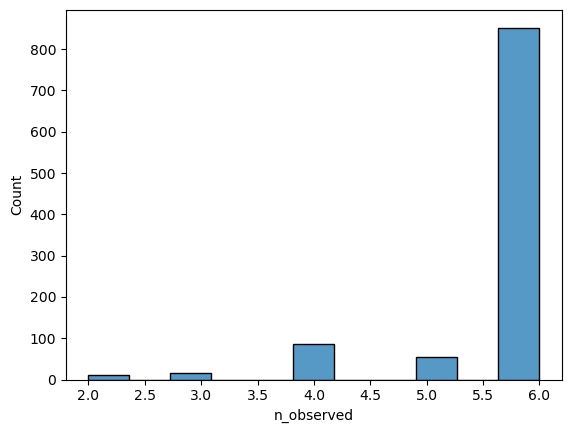

In [13]:
sns.histplot(data=exp_predict_F3F4, x='n_observed')

Although outlier removal has been performed in the SortSeq data, almost all F3-F4 mutants have been observed in 4+ culture replicates!

### Preparing the data on predicted TFBS

In [16]:
TFBS_hits['FCY1_start'] = TFBS_hits['Start Pos'] - 205
TFBS_hits['FCY1_end'] = TFBS_hits['End Pos'] - 205
# Computing the mid point
TFBS_hits = TFBS_hits.infer_objects()
TFBS_hits['FCY1_midpoint'] = 0.0
for row in range(TFBS_hits.shape[0]):
    start_pos = TFBS_hits.at[row, 'FCY1_start']
    end_pos = TFBS_hits.at[row, 'FCY1_end']
    midpoint = np.median([start_pos, end_pos])
    TFBS_hits.at[row, 'FCY1_midpoint'] = midpoint

In [17]:
# Keeping only the TFBS with a midpoint in the F3F4 region
TFBS_F3F4 = TFBS_hits[TFBS_hits['FCY1_midpoint'] >= -153].copy().reset_index(drop=True)

In [18]:
# Defining a function to plot a rugplot on the top axis
# Taken from https://stackoverflow.com/questions/55066869/matplotlib-seaborn-how-to-plot-a-rugplot-on-the-top-edge-of-x-axis
# Answer from user ImportanceOfBeingErnest

def upper_rugplot(data, height=.05, ax=None, **kwargs):
    from matplotlib.collections import LineCollection
    ax = ax or plt.gca()
    kwargs.setdefault("linewidth", 1)
    segs = np.stack((np.c_[data, data],
                     np.c_[np.ones_like(data), np.ones_like(data)-height]),
                    axis=-1)
    lc = LineCollection(segs, transform=ax.get_xaxis_transform(), **kwargs)
    ax.add_collection(lc)

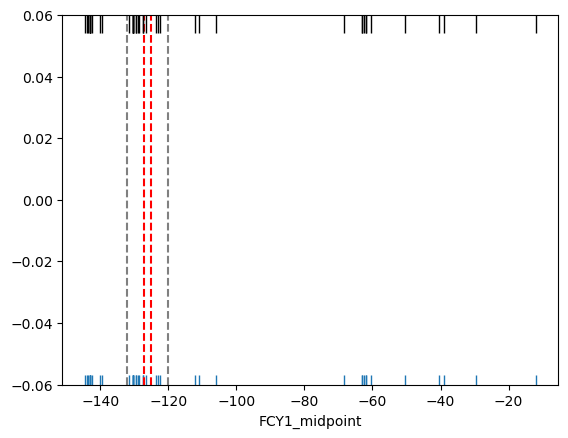

In [19]:
sns.rugplot(data=TFBS_F3F4, x="FCY1_midpoint")
plt.axvline(x=-132, c='grey', linestyle='--')
plt.axvline(x=-127, c='red', linestyle='--')
plt.axvline(x=-125, c='red', linestyle='--')
plt.axvline(x=-120, c='grey', linestyle='--')
upper_rugplot(TFBS_F3F4["FCY1_midpoint"], ax=plt.gca(), edgecolor='black')

This works beautifully!

### Mutational effects on expression along the F3-F4 region (for panel E)

#### Confidence interval by position

In [23]:
# Computing medians and most extreme CI bounds by position
mut_effects_by_pos = exp_predict_F3F4[['Median_rel_exp', 'Mutation type', 'FCY1_position']].groupby(by=['Mutation type', 'FCY1_position'],
                                                                                                               as_index=False).median()
min_by_pos = exp_predict_F3F4[['bot_2_5percent', 'Mutation type', 'FCY1_position']].groupby(by=['Mutation type', 'FCY1_position'],
                                                                                                               as_index=False).min()
max_by_pos = exp_predict_F3F4[['top_97_5percent', 'Mutation type', 'FCY1_position']].groupby(by=['Mutation type', 'FCY1_position'],
                                                                                                               as_index=False).max()

mut_effects_by_pos = pd.merge(mut_effects_by_pos, min_by_pos, on=['Mutation type', 'FCY1_position'], how='outer')
mut_effects_by_pos = pd.merge(mut_effects_by_pos, max_by_pos, on=['Mutation type', 'FCY1_position'], how='outer')

# dfs are made for each type of mutations, adding nans for absent positions
all_positions = list(range(-153, 1))  # Right now, the FCY1 CDS begins at 1, such
                                      # that F3-F4 is from -153 to 0.
sub_by_pos = mut_effects_by_pos[mut_effects_by_pos['Mutation type'] == 'Substitution'].copy().reset_index(drop=True)
pos_not_sub = [x if x not in sub_by_pos['FCY1_position'].unique() else np.nan for x in all_positions]
pos_not_sub = np.array(pos_not_sub)[~np.isnan(np.array(pos_not_sub))]
# There are no missing positions for substitutions (as expeted)
sub_by_pos = sub_by_pos.sort_values(by=['FCY1_position']).reset_index(drop=True)

ins_by_pos = mut_effects_by_pos[mut_effects_by_pos['Mutation type'] == 'Insertion'].copy().reset_index(drop=True)
pos_not_ins = [x if x not in ins_by_pos['FCY1_position'].unique() else np.nan for x in all_positions]
pos_not_ins = np.array(pos_not_ins)[~np.isnan(np.array(pos_not_ins))]
# There are no missing positions for insertions (as expected)
ins_by_pos = ins_by_pos.sort_values(by=['FCY1_position']).reset_index(drop=True)

del_by_pos = mut_effects_by_pos[mut_effects_by_pos['Mutation type'] == 'Deletion'].copy().reset_index(drop=True)
pos_not_del = [x if x not in del_by_pos['FCY1_position'].unique() else np.nan for x in all_positions]
pos_not_del = np.array(pos_not_del)[~np.isnan(np.array(pos_not_del))]
# Adding NaN values for the missing positions (as expected) in the deletions
del_nan = pd.DataFrame(columns=del_by_pos.columns)
del_nan['FCY1_position'] = pos_not_del
del_nan['Mutation type'] = 'Deletion'
#del_nan['Median_rel_exp'] = 1.0
del_nan[['Median_rel_exp', 'bot_2_5percent', 'top_97_5percent']] = np.nan

del_by_pos = pd.concat([del_by_pos, del_nan]).reset_index(drop=True)
del_by_pos = del_by_pos.sort_values(by=['FCY1_position']).reset_index(drop=True)

In [24]:
mut_palette = {'Substitution': cm.tab10.colors[9], 
               'Insertion': cm.tab20b.colors[1],
               'Deletion': cm.tab10.colors[3]}

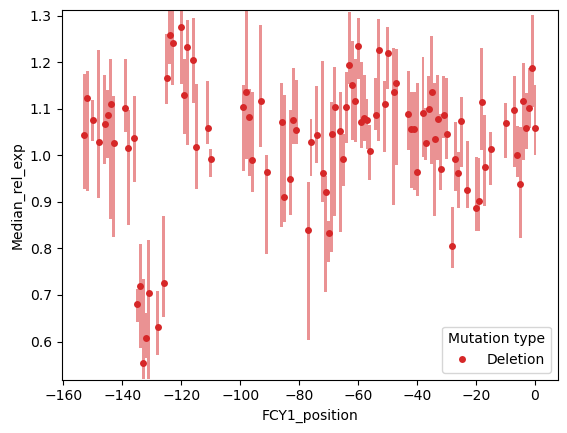

In [25]:
sns.stripplot(data=del_by_pos, x='FCY1_position', y='Median_rel_exp', hue='Mutation type',
              palette=mut_palette, native_scale=True)

for row in range(del_by_pos.shape[0]):
    mut_coord = del_by_pos.at[row, 'FCY1_position']
    rect_left = mut_coord-0.5

    rect_min = del_by_pos.at[row, 'bot_2_5percent']
    rect_height = del_by_pos.at[row, 'top_97_5percent'] - del_by_pos.at[row, 'bot_2_5percent']

    plt.gca().add_patch(Rectangle((rect_left, rect_min), 1, rect_height, facecolor=mut_palette['Deletion'],
                                  edgecolor=None, alpha=0.5))
    

This approach works well to draw confidence intervals **only** at actually mutated positions.

Let's define a function to reuse it when generating the final figure:

In [28]:
def filled_ci(data, x, ymin, ymax, width, color, alpha, ax):
    # Iteratively plotting all corresponding rectangles
    for df_row in data.iterrows():
        mut_coord = int(df_row[1][x])
        rect_left = mut_coord-(width/2)
        
        rect_min = float(df_row[1][ymin])
        rect_height = float(df_row[1][ymax]) - rect_min

        ax.add_patch(Rectangle((rect_left, rect_min), width, rect_height, facecolor=color, edgecolor=None, alpha=alpha))
    

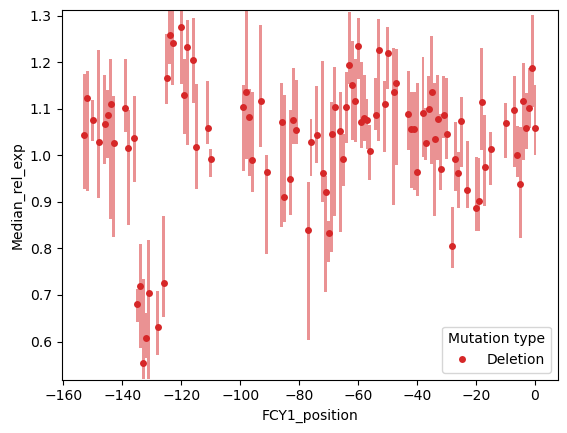

In [29]:
test_ci = sns.stripplot(data=del_by_pos, x='FCY1_position', y='Median_rel_exp', hue='Mutation type',
                        palette=mut_palette, native_scale=True)

filled_ci(del_by_pos, 'FCY1_position', 'bot_2_5percent', 'top_97_5percent', 1, mut_palette['Deletion'], 0.5, test_ci)

#### Individual effects by "significant" mutation

In [31]:
# Keeping the effects of individual mutations which are "significantly" different from WT
# Let's arbitrarily choose mutations where the CI does not get lower than a 5% difference
exp_predict_hits = exp_predict_F3F4[(exp_predict_F3F4['bot_2_5percent'] > 1.05) | (exp_predict_F3F4['top_97_5percent'] < 0.95)].copy().reset_index(drop=True)

sub_hits = exp_predict_hits[exp_predict_hits['Mutation type'] == 'Substitution'].copy().reset_index(drop=True)
ins_hits = exp_predict_hits[exp_predict_hits['Mutation type'] == 'Insertion'].copy().reset_index(drop=True)
del_hits = exp_predict_hits[exp_predict_hits['Mutation type'] == 'Deletion'].copy().reset_index(drop=True)

In [32]:
exp_predict_F3F4[(exp_predict_F3F4['bot_2_5percent'] > 1.05) | (exp_predict_F3F4['top_97_5percent'] < 0.95)]

,Genotype,Median_rel_exp,bot_2_5percent,bot_5percent,top_95percent,top_97_5percent,Mutation type,Position,In_F3F4,n_observed,FCY1_position
11,D-128_1nt_Cto-,0.840547,0.603160,0.642852,0.935944,0.943599,Deletion,128.0,True,6.0,-77.0
16,D-135_1nt_Ato-,0.833148,0.770010,0.785745,0.854811,0.858925,Deletion,135.0,True,6.0,-70.0
22,D-142_1nt_Gto-,1.194154,1.152343,1.158937,1.285753,1.307826,Deletion,142.0,True,6.0,-63.0
25,D-145_1nt_Cto-,1.233465,1.164670,1.175249,1.286423,1.295054,Deletion,145.0,True,6.0,-60.0
30,D-151_1nt_Gto-,1.086294,1.054094,1.059511,1.149268,1.166455,Deletion,151.0,True,6.0,-54.0
...,...,...,...,...,...,...,...,...,...,...,...
1002,S-94_1nt_CtoG,1.155254,1.079254,1.091664,1.292055,1.334572,Substitution,94.0,True,6.0,-111.0
1004,S-95_1nt_TtoA,1.172947,1.115419,1.125586,1.219545,1.227150,Substitution,95.0,True,6.0,-110.0
1006,S-95_1nt_TtoG,1.185085,1.099374,1.113315,1.297336,1.312196,Substitution,95.0,True,6.0,-110.0
1008,S-96_1nt_TtoC,1.177797,1.121569,1.136019,1.421510,1.443248,Substitution,96.0,True,6.0,-109.0


## Assembling the figure

In [34]:
# Shortening the 'Mutation type' labels
short_types = {'Substitution': 'Sub', 'Insertion': 'Ins', 'Deletion': 'Del'}

exp_predict_F3F4['Mutation type'] = exp_predict_F3F4['Mutation type'].apply(lambda x: short_types[x])
sub_hits['Mutation type'] = sub_hits['Mutation type'].apply(lambda x: short_types[x])
ins_hits['Mutation type'] = ins_hits['Mutation type'].apply(lambda x: short_types[x])
del_hits['Mutation type'] = del_hits['Mutation type'].apply(lambda x: short_types[x])

In [35]:
# Also updating the 'Genotype_category' in sort_dist_all
# Before, secondary mutations upstream of the F3-F4 region are removed
sort_dist_muts = sort_dist_all[sort_dist_all['FCY1_position'] >= -153].copy().reset_index(drop=True)

sort_muts_dict = {'F3-F4': 'Promoter', 'Other': 'CDS'}
sort_dist_muts['Genotype_category'] = sort_dist_muts['Genotype_category'].apply(lambda x: sort_muts_dict[x])
sort_comp['Genotype_category'] = sort_comp['Genotype_category'].apply(lambda x: sort_muts_dict[x])

In [36]:
mut_palette = {'Sub': cm.tab10.colors[9], 
               'Ins': cm.tab20b.colors[1],
               'Del': cm.tab10.colors[3]}

mutants_palette = sns.color_palette('crest_r', 2)
loc_palette = {'CDS': mutants_palette[0],
               'Promoter': mutants_palette[1]}

ins_hits['FCY1_position'] += 1  # The coordinates of insertions had not been adjusted
ins_by_pos['FCY1_position'] += 1  # Same for the data to add the filled CI

C:\Users\tiger\AppData\Local\Temp\ipykernel_33564\665686782.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels(['Sub', 'Ins', 'Del'])


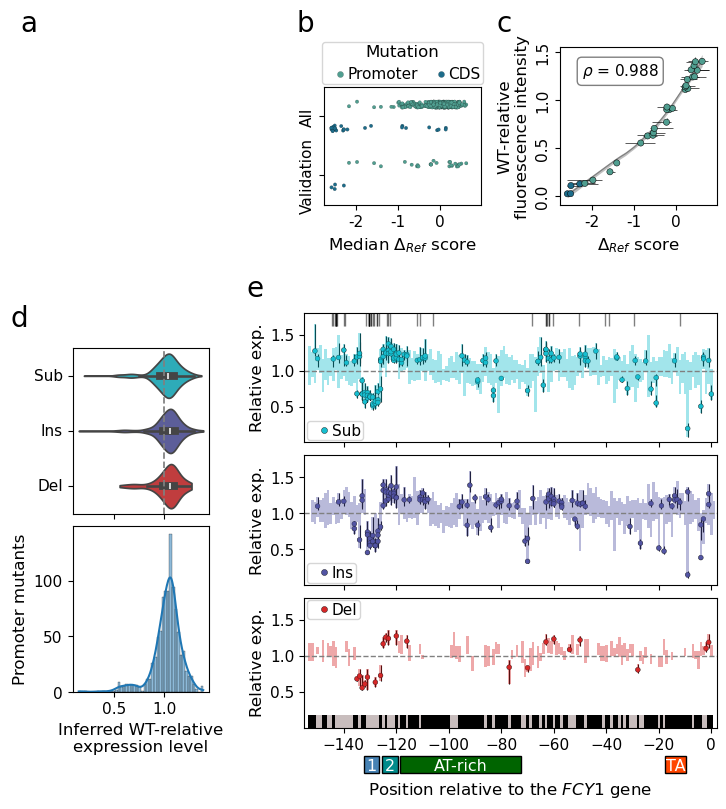

In [37]:
fig = plt.figure(constrained_layout=False, figsize=(6.48, 7))

# Creating a single gridspec were all axes will be drawn
gs1 = fig.add_gridspec(nrows=177, ncols=165, left=0, right=1, bottom=0, top=1 )

# ax for the sortseq schematics
ax1 = fig.add_subplot(gs1[5:45, 0:55])

# axes for distribution of scores and calibration curve
ax2 = fig.add_subplot(gs1[15:45, 65:105])
ax3 = fig.add_subplot(gs1[5:45, 125:165], sharex=ax2)

# axes for distribution of mutational effects
ax4 = fig.add_subplot(gs1[81:123, 1:36]) 
ax5 = fig.add_subplot(gs1[126:168:, 1:36], sharex=ax4)

# axes for mutational effects along fragment
ax6 = fig.add_subplot(gs1[72:105, 60:165])
ax7 = fig.add_subplot(gs1[108:141, 60:165], sharex=ax6, sharey=ax6)
ax8 = fig.add_subplot(gs1[144:177, 60:165], sharex=ax6, sharey=ax6)

# Removing ticks for A, where a schematics will be added manually
ax1.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax1.spines[:].set_visible(False)

# Panel B
sns.stripplot(data=sort_dist_muts, x='Median_delta_WT', y='Mutants_set', hue='Genotype_category',
              palette=loc_palette, hue_order=['Promoter', 'CDS'], size=2.5, ax=ax2, dodge=True, edgecolor='black',
              linewidth=0.1)

h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, l2, handletextpad=-0.5, title='Mutation', loc="upper center",
           bbox_to_anchor=(0.5, 1.4), borderaxespad=0.15, borderpad=0.15, ncols=2,
           title_fontsize=12, fontsize=11, markerscale=1.75, columnspacing=0.5)

ax2.set_xticks([-2, -1, 0], labels=[-2, -1, 0], fontsize=11)
ax2.set_xlabel(r"Median $\Delta_{Ref}$ score", fontsize=12)
ax2.set_ylabel('')
ax2.tick_params(axis='y', labelrotation=90, labelsize=11)
for tick in ax2.yaxis.get_majorticklabels():
    tick.set_verticalalignment("center")

# Panel C
sns.scatterplot(data=sort_comp, x='Median_delta_WT', y='Relative_median_exp', hue='Genotype_category', palette=loc_palette,
                ax=ax3, legend=False, edgecolor='black', s=20, zorder=3)

ax3.errorbar(sort_comp['Median_delta_WT'], sort_comp['Relative_median_exp'], xerr=fit_scores_err, yerr=fit_exp_err,
             fmt='none', zorder=2, ecolor='black', linewidth=0.45)
ax3.plot(curve_eval_df['Median_delta_WT'], curve_eval_df['Median_rel_exp'], c="grey", zorder=1, linewidth=0.85)
ax3.fill_between(curve_eval_df['Median_delta_WT'], curve_eval_df['bot_2_5percent'], curve_eval_df['top_97_5percent'], alpha=0.5, color="grey",
                 zorder=1, linewidth=0)
ax3.tick_params(axis='x', labelsize=11)
ax3.tick_params(axis='y', labelsize=11, labelrotation=90)
for tick in ax3.yaxis.get_majorticklabels():
    tick.set_verticalalignment("center")

# Adding spearman's rho
calib_rho = stats.spearmanr(sort_comp['Median_delta_WT'], sort_comp['Relative_median_exp'])

ax3.set_xlabel(r"$\Delta_{Ref}$ score", fontsize=12)
ax3.set_ylabel('WT-relative\nfluorescence intensity', fontsize=12)
ax3.annotate(r"$\rho$ = "f'{round(calib_rho[0], 3)}',
             (-2.25, 1.25), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=11)

# Panel D: Distribution of mutational effects

sns.violinplot(data=exp_predict_F3F4, y='Mutation type', x='Median_rel_exp', hue='Mutation type',
               palette=mut_palette, order=['Sub', 'Ins', 'Del'], cut=0, ax=ax4)
ax4.set_yticklabels(['Sub', 'Ins', 'Del'])
ax4.set_ylabel('')
ax4.set_xlabel('')
ax4.tick_params(axis='y', labelsize=11)
for tick in ax4.yaxis.get_majorticklabels():
    tick.set_verticalalignment("center")
ax4.axvline(x=1.0, c='grey', linestyle='--', linewidth=1.25)
ax4.tick_params(labelbottom=False)

sns.histplot(data=exp_predict_F3F4, x='Median_rel_exp', ax=ax5, kde=True)
ax5.tick_params(axis='both', labelsize=11)
ax5.set_ylabel('Promoter mutants', fontsize=12)
ax5.set_xlabel('Inferred WT-relative\nexpression level', fontsize=12)

# Panel E: effects along the sequence
sns.scatterplot(data=sub_hits, x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, s=12,
               ax=ax6, edgecolor='black')
sub_err = np.array([sub_hits['Median_rel_exp'] - sub_hits['bot_2_5percent'],
                    sub_hits['top_97_5percent'] - sub_hits['Median_rel_exp']])
ax6.errorbar(sub_hits['FCY1_position'], sub_hits['Median_rel_exp'], yerr=sub_err,
             fmt='none', zorder=0, ecolor='black', linewidth=0.8)
filled_ci(sub_by_pos, 'FCY1_position', 'bot_2_5percent', 'top_97_5percent', 1, mut_palette['Sub'], 0.4, ax6)
upper_rugplot(TFBS_F3F4["FCY1_midpoint"], ax=ax6, edgecolor='black', height=0.1, alpha=0.5, linewidth=1)  # To add midpoints of TFBS

sns.scatterplot(data=ins_hits, x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, s=12,
               ax=ax7, edgecolor='black')
ins_err = np.array([ins_hits['Median_rel_exp'] - ins_hits['bot_2_5percent'],
                    ins_hits['top_97_5percent'] - ins_hits['Median_rel_exp']])
ax7.errorbar(ins_hits['FCY1_position'], ins_hits['Median_rel_exp'], yerr=ins_err,
             fmt='none', zorder=0, ecolor='black', linewidth=0.8)
filled_ci(ins_by_pos, 'FCY1_position', 'bot_2_5percent', 'top_97_5percent', 1, mut_palette['Ins'], 0.4, ax7)

sns.scatterplot(data=del_hits, x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, s=12,
               ax=ax8, edgecolor='black')
del_err = np.array([del_hits['Median_rel_exp'] - del_hits['bot_2_5percent'],
                    del_hits['top_97_5percent'] - del_hits['Median_rel_exp']])
ax8.errorbar(del_hits['FCY1_position'], del_hits['Median_rel_exp'], yerr=del_err,
             fmt='none', zorder=0, ecolor='black', linewidth=0.8)
filled_ci(del_by_pos, 'FCY1_position', 'bot_2_5percent', 'top_97_5percent', 1, mut_palette['Del'], 0.4, ax8)

# Adding the AT content of the F3-F4 region
seq_F3F4 = "attccttgcaggggcggtagtacccggagaccctgaacttttctttttttttttgcgaaattaaaaagttcattttcaattcgacaatgagatctacaagccattgttttatgttgatgagagccagcttaaagagttaaaaatttcatagcta".upper()
range_indices = list(range(-153, 1))
rect_bottom = ax8.get_ylim()[0]
for list_index in range(154):
    nt_current = seq_F3F4[list_index]
    pos_current = range_indices[list_index]
    rect_start = pos_current - 0.5
    if nt_current in ['A', 'T']:
        patch_col = 'black'
    elif nt_current in ['G', 'C']:
        patch_col = '#c8bdbd'
        
    ax8.add_patch(Rectangle((rect_start, rect_bottom), 1, 0.175, facecolor=patch_col, edgecolor=None, clip_on=False))
for ax_F3F4 in [ax6, ax7, ax8]:
    ax_F3F4.axhline(y=1, c='grey', linestyle='--', linewidth=1)
    h_ax, l_ax = ax_F3F4.get_legend_handles_labels()
    if ax_F3F4 == ax8:
        ax_F3F4.legend(h_ax, l_ax, handletextpad=-0.5, title=None, loc="upper left",
                       borderaxespad=0.15, borderpad=0.15, fontsize=11, markerscale=1.25)
    else:
        ax_F3F4.legend(h_ax, l_ax, handletextpad=-0.5, title=None, loc="lower left",
                       borderaxespad=0.15, borderpad=0.15, fontsize=11, markerscale=1.25)
    ax_F3F4.tick_params(axis='both', labelsize=11)
    ax_F3F4.set_xlim(left=-155, right=2)
    ax_F3F4.set_ylabel('Relative exp.', fontsize=12)

ax6.tick_params(labelbottom=False)
ax6.set_xlabel('')
ax7.tick_params(labelbottom=False)
ax7.set_xlabel('')

# Adding the schematics of regions of interest
ax8.add_patch(Rectangle((-132.5, -0.4), 6, -0.23, facecolor='steelblue', edgecolor='black', clip_on=False))  # Site 1
ax8.annotate("1", (-129.5, -0.525), annotation_clip=False, color='white', ha='center', va='center', fontsize=11.5, zorder=1)
ax8.add_patch(Rectangle((-125.5, -0.4), 6, -0.23, facecolor='darkcyan', edgecolor='black', clip_on=False))  # Site 2
ax8.annotate("2", (-122.5, -0.525), annotation_clip=False, color='white', ha='center', va='center', fontsize=11.5, zorder=1)
ax8.add_patch(Rectangle((-118.5, -0.4), 46, -0.23, facecolor='darkgreen', edgecolor='black', clip_on=False)) # AT-rich region
ax8.annotate("AT-rich", (-95.5, -0.525), annotation_clip=False, color='white', ha='center', va='center', fontsize=11.5, zorder=1)
ax8.add_patch(Rectangle((-17.5, -0.4), 8, -0.23, facecolor='orangered', edgecolor='black', clip_on=False))  # TATA-like element
ax8.annotate("TA", (-13.5, -0.525), annotation_clip=False, color='white', ha='center', va='center', fontsize=11.5, zorder=1)

ax8.set_xlabel(r"Position relative to the $\it{FCY1}$ gene", fontsize=12, labelpad=20)

# Adding subfigure labels
ax1.annotate('a', (-35, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax2.annotate('b', (-20, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax3.annotate('c', (-46, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax4.annotate('d', (-45, 135), xycoords='axes points', annotation_clip=False, fontsize=20)
ax6.annotate('e', (-42, 105), xycoords='axes points', annotation_clip=False, fontsize=20)
    
fig5 = plt.gcf()
fig5.savefig(f"Final_figs/Fig5.tiff", bbox_inches='tight')

In [38]:
sort_dist_muts[(sort_dist_muts['Genotype_category'] == 'CDS') & (sort_dist_muts['Mutants_set'] == 'All')].shape

(28, 14)

In [819]:
TFBS_F3F4

,Start Pos,End Pos,Strand,% of Max Score,Hit Seq,Motif,FCY1_start,FCY1_end,FCY1_midpoint
0,57,64,-,87.6,CCCCTGCA,SOK2 motif #404,-148,-141,-144.5
1,58,64,+,85.7,GCAGGGG,REI1 motif #489,-147,-141,-144.0
2,59,64,+,93.8,CAGGGG,HAA1 motif #1425,-146,-141,-143.5
3,59,66,+,81.4,CAGGGGCG,NRG2 motif #1383,-146,-139,-142.5
4,59,65,+,100.0,CAGGGGC,MSN2 motif #1380,-146,-140,-143.0
5,60,64,-,100.0,CCCCT,MSN4 motif #518,-145,-141,-143.0
6,60,64,+,100.0,AGGGG,USV1 motif #509,-145,-141,-143.0
7,60,64,-,100.0,CCCCT,RGM1 motif #531,-145,-141,-143.0
8,61,70,-,81.1,CTACCGCCCC,UME6 motif #2239,-144,-135,-139.5
9,61,69,+,77.9,GGGGCGGTA,CRZ1 motif #516,-144,-136,-140.0


In [820]:
calib_rho

SignificanceResult(statistic=0.9879866518353726, pvalue=2.9680077148912373e-24)

### Making a different version to be cropped for use in talks

In [822]:
# Preparing arrays of difference for erro bars
sort_talk = sort_comp[sort_comp['Genotype_category'] == 'Promoter'].copy().reset_index(drop=True)

exp_err_talk = np.array([sort_talk['Relative_median_exp'] - sort_talk['Min_rel_exp'],
                         sort_talk['Max_rel_exp'] - sort_talk['Relative_median_exp']])
scores_err_talk = np.array([sort_talk['Median_delta_WT'] - sort_talk['Min_delta_WT'],
                            sort_talk['Max_delta_WT'] - sort_talk['Median_delta_WT']])

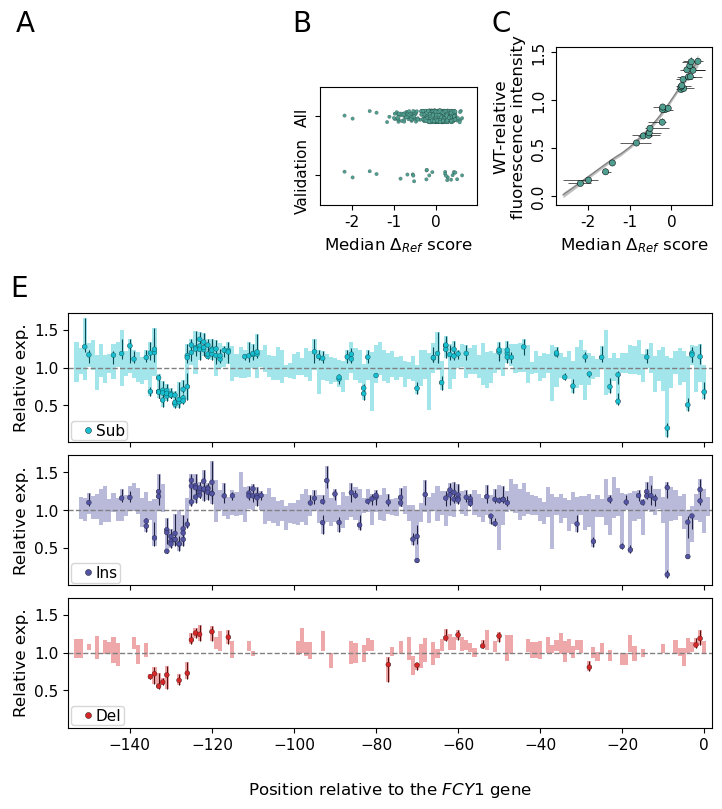

In [823]:
# Talk version
fig = plt.figure(constrained_layout=False, figsize=(6.48, 7))

# Creating a single gridspec were all axes will be drawn
gs1 = fig.add_gridspec(nrows=177, ncols=165, left=0, right=1, bottom=0, top=1 )

# ax for the sortseq schematics
ax1 = fig.add_subplot(gs1[5:45, 0:55])

# axes for distribution of scores and calibration curve
ax2 = fig.add_subplot(gs1[15:45, 65:105])
ax3 = fig.add_subplot(gs1[5:45, 125:165], sharex=ax2)

# axes for mutational effects along fragment
ax6 = fig.add_subplot(gs1[72:105, 1:165])
ax7 = fig.add_subplot(gs1[108:141, 1:165], sharex=ax6, sharey=ax6)
ax8 = fig.add_subplot(gs1[144:177, 1:165], sharex=ax6, sharey=ax6)

# Removing ticks for A, where a schematics will be added manually
ax1.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax1.spines[:].set_visible(False)

# Panel B
sort_dist_talk = sort_dist_muts[sort_dist_muts['Genotype_category'] == 'Promoter'].copy().reset_index(drop=True)
sns.stripplot(data=sort_dist_talk, x='Median_delta_WT', y='Mutants_set', hue='Genotype_category',
              palette=loc_palette, hue_order=['Promoter'], size=2.5, ax=ax2, dodge=True, edgecolor='black',
              linewidth=0.1, legend=False)

ax2.set_xticks([-2, -1, 0], labels=[-2, -1, 0], fontsize=11)
ax2.set_xlabel(r"Median $\Delta_{Ref}$ score", fontsize=12)
ax2.set_ylabel('')
ax2.tick_params(axis='y', labelrotation=90, labelsize=11)
for tick in ax2.yaxis.get_majorticklabels():
    tick.set_verticalalignment("center")

# Panel C
sns.scatterplot(data=sort_talk, x='Median_delta_WT', y='Relative_median_exp', hue='Genotype_category', palette=loc_palette,
                ax=ax3, legend=False, edgecolor='black', s=20, zorder=3)

ax3.errorbar(sort_talk['Median_delta_WT'], sort_talk['Relative_median_exp'], xerr=scores_err_talk, yerr=exp_err_talk,
             fmt='none', zorder=2, ecolor='black', linewidth=0.45)
ax3.plot(curve_eval_df['Median_delta_WT'], curve_eval_df['Median_rel_exp'], c="grey", zorder=1, linewidth=0.85)
ax3.fill_between(curve_eval_df['Median_delta_WT'], curve_eval_df['bot_2_5percent'], curve_eval_df['top_97_5percent'], alpha=0.5, color="grey",
                 zorder=1, linewidth=0)
ax3.tick_params(axis='x', labelsize=11)
ax3.tick_params(axis='y', labelsize=11, labelrotation=90)
for tick in ax3.yaxis.get_majorticklabels():
    tick.set_verticalalignment("center")

ax3.set_xlabel(r"Median $\Delta_{Ref}$ score", fontsize=12)
ax3.set_ylabel('WT-relative\nfluorescence intensity', fontsize=12)

# Panel E: effects along the sequence
sns.scatterplot(data=sub_hits, x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, s=12,
               ax=ax6, edgecolor='black')
sub_err = np.array([sub_hits['Median_rel_exp'] - sub_hits['bot_2_5percent'],
                    sub_hits['top_97_5percent'] - sub_hits['Median_rel_exp']])
ax6.errorbar(sub_hits['FCY1_position'], sub_hits['Median_rel_exp'], yerr=sub_err,
             fmt='none', zorder=0, ecolor='black', linewidth=0.8)
filled_ci(sub_by_pos, 'FCY1_position', 'bot_2_5percent', 'top_97_5percent', 1, mut_palette['Sub'], 0.4, ax6)
#upper_rugplot(TFBS_F3F4["FCY1_midpoint"], ax=ax6, edgecolor='black', height=0.1, alpha=0.5, linewidth=1)  # To add midpoints of TFBS

sns.scatterplot(data=ins_hits, x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, s=12,
               ax=ax7, edgecolor='black')
ins_err = np.array([ins_hits['Median_rel_exp'] - ins_hits['bot_2_5percent'],
                    ins_hits['top_97_5percent'] - ins_hits['Median_rel_exp']])
ax7.errorbar(ins_hits['FCY1_position'], ins_hits['Median_rel_exp'], yerr=ins_err,
             fmt='none', zorder=0, ecolor='black', linewidth=0.8)
filled_ci(ins_by_pos, 'FCY1_position', 'bot_2_5percent', 'top_97_5percent', 1, mut_palette['Ins'], 0.4, ax7)

sns.scatterplot(data=del_hits, x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, s=12,
               ax=ax8, edgecolor='black')
del_err = np.array([del_hits['Median_rel_exp'] - del_hits['bot_2_5percent'],
                    del_hits['top_97_5percent'] - del_hits['Median_rel_exp']])
ax8.errorbar(del_hits['FCY1_position'], del_hits['Median_rel_exp'], yerr=del_err,
             fmt='none', zorder=0, ecolor='black', linewidth=0.8)
filled_ci(del_by_pos, 'FCY1_position', 'bot_2_5percent', 'top_97_5percent', 1, mut_palette['Del'], 0.4, ax8)

for ax_F3F4 in [ax6, ax7, ax8]:
    ax_F3F4.axhline(y=1, c='grey', linestyle='--', linewidth=1)
    h_ax, l_ax = ax_F3F4.get_legend_handles_labels()
    ax_F3F4.legend(h_ax, l_ax, handletextpad=-0.5, title=None, loc="lower left",
                   borderaxespad=0.15, borderpad=0.15, fontsize=11, markerscale=1.25)
    ax_F3F4.tick_params(axis='both', labelsize=11)
    ax_F3F4.set_xlim(left=-155, right=2)
    ax_F3F4.set_ylabel('Relative exp.', fontsize=12)

ax6.tick_params(labelbottom=False)
ax6.set_xlabel('')
ax7.tick_params(labelbottom=False)
ax7.set_xlabel('')

ax8.set_xlabel(r"Position relative to the $\it{FCY1}$ gene", fontsize=12, labelpad=20)

# Adding subfigure labels
ax1.annotate('A', (-35, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax2.annotate('B', (-20, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax3.annotate('C', (-46, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax6.annotate('E', (-42, 105), xycoords='axes points', annotation_clip=False, fontsize=20)
    
fig5_talk = plt.gcf()
fig5_talk.savefig(f"Final_figs/Fig5_talk.tiff", bbox_inches='tight')

In [824]:
TFBS_F3F4[(TFBS_F3F4['FCY1_end'] >= -133) & (TFBS_F3F4['FCY1_start'] <= -118)].sort_values(by='FCY1_start')

,Start Pos,End Pos,Strand,% of Max Score,Hit Seq,Motif,FCY1_start,FCY1_end,FCY1_midpoint
10,69,78,-,77.3,TCCGGGTACT,ASG1 motif #2116,-136,-127,-131.5
11,70,79,+,86.0,GTACCCGGAG,ECM22 motif #2122,-135,-126,-130.5
12,70,79,-,78.4,CTCCGGGTAC,ARO80 motif #2115,-135,-126,-130.5
13,70,79,-,84.6,CTCCGGGTAC,PUT3 motif #2223,-135,-126,-130.5
14,70,79,+,78.8,GTACCCGGAG,RDR1 motif #2158,-135,-126,-130.5
15,72,79,+,79.6,ACCCGGAG,YER184C motif #512,-133,-126,-129.5
16,72,81,+,75.4,ACCCGGAGAC,PUT3 motif #2223,-133,-124,-128.5
17,72,77,+,100.0,ACCCGG,YDR026C motif #696,-133,-128,-130.5
18,73,78,+,95.3,CCCGGA,PDR3 motif #1387,-132,-127,-129.5
19,73,82,+,86.0,CCCGGAGACC,ASG1 motif #2116,-132,-123,-127.5


## Exporting a final dataframe of relative expression estimates for all single mutants (Supp Table 9)

In [826]:
# Reusing exp_predict_muts, but adjusting the FCY1_position of insertions
# (as in the figure)
exp_predict_muts['FCY1_position'] = exp_predict_muts['Position'] - 205 + 1*(exp_predict_muts['Mutation type'] == 'Insertion')
exp_predict_muts = exp_predict_muts.sort_values(by='FCY1_position')
#exp_predict_muts.to_csv("Supp_data/SuppTable9.csv")

## Exporting Supp Table 10 (with predicted TFBS)

In [864]:
TFBS_F3F4.to_csv("Supp_data/SuppTable10.csv")